### Target :- 
    - Take the model submitted for assignment 4, and reduce the number of kernels in each layer such that the number of parameters in the model are less than 10k 
### Results :- 
    - Total number of parameters = 8162
    - Best Train and Validation accuracy = 98.93% (14th epoch) and 99.25% (13th epoch) respectively

### Analysis :- 
    - Naively reducing the number of kernels from the previous submission gives me a decent base to begin with. I'm repeating a bunch of 3 * 3 Convolution layers after the first layer
      which stack up the parameter count without increasing the number of kernels available for feature extraction. 
    - The validation accuracy does not improve consistently with the number of epochs. It peaks at 99.25% and then drops down again to 99.02 in the final epoch. The model performance can be finetuned with varying the optimizer and learning rates, which I will experiment with later. 
 


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np 
%matplotlib inline



In [33]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.mnist_model = nn.Sequential(
            nn.Conv2d(1, 8, 3, bias=False, padding=1), #RF = 3
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.1),
            nn.Conv2d(8, 8, 3, bias=False, padding=1), # RF = 5
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.1),
            nn.Conv2d(8, 8, 3, bias=False, padding=1), # RF = 7
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.1),
            nn.Conv2d(8, 8, 3, bias=False, padding=1), # RF = 9
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2), # RF = 10
            nn.Dropout(0.25),
            nn.Conv2d(8, 16, 1, bias=False), # RF = 14
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1),
            nn.Conv2d(16, 16, 3, bias=False), # RF = 18
            nn.ReLU(),
            nn.BatchNorm2d(16),

            nn.MaxPool2d(2,2), # RF = 20
            nn.Dropout(0.25),
            nn.Conv2d(16,16,3), # RF = 28
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 10, 3), # RF = 36
            nn.AvgPool2d(2)
            
        )
        
    def forward(self, x):
        x = self.mnist_model(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [34]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             576
              ReLU-6            [-1, 8, 28, 28]               0
       BatchNorm2d-7            [-1, 8, 28, 28]              16
           Dropout-8            [-1, 8, 28, 28]               0
            Conv2d-9            [-1, 8, 28, 28]             576
             ReLU-10            [-1, 8, 28, 28]               0
      BatchNorm2d-11            [-1, 8, 28, 28]              16
          Dropout-12            [-1, 8, 28, 28]               0
           Conv2d-13            [-1, 8, 28, 28]             576
             ReLU-14            [-1, 8,

In [35]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)) ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

In [36]:

train_losses = []
test_losses = []
train_acc = []
test_acc = []
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):

    model.train()
    correct_train = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        train_pred = output.argmax(dim = 1,keepdim = True)
        correct_train += train_pred.eq(target.view_as(train_pred)).sum().item()
        
        for param in optimizer.param_groups:
          lr = param['lr']
        pbar.set_description(desc= f'epoch = {epoch + 1} loss={loss.item()} batch_id={batch_idx} learning_rate={lr} train_accuracy={correct_train * 100.0/len(train_loader.dataset)}')
    train_acc.append(correct_train * 100.0/len(train_loader.dataset))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_acc.append(100. * correct / len(test_loader.dataset))

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [37]:
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.90)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]EPOCH: 1
epoch = 1 loss=0.12179797887802124 batch_id=468 learning_rate=0.03 train_accuracy=92.98166666666667: 100%|██████████| 469/469 [00:12<00:00, 37.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]
Test set: Average loss: 0.0591, Accuracy: 9796/10000 (98%)

EPOCH: 2
epoch = 2 loss=0.030969733372330666 batch_id=468 learning_rate=0.03 train_accuracy=97.61666666666666: 100%|██████████| 469/469 [00:13<00:00, 34.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]
Test set: Average loss: 0.0355, Accuracy: 9886/10000 (99%)

EPOCH: 3
epoch = 3 loss=0.058448974043130875 batch_id=468 learning_rate=0.03 train_accuracy=98.10333333333334: 100%|██████████| 469/469 [00:13<00:00, 33.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]
Test set: Average loss: 0.0405, Accuracy: 9866/10000 (99%)

EPOCH: 4
epoch = 4 loss=0.08448977023363113 batch_id=468 learning_rate=0.03 train_accuracy=98.21: 100%|██████████| 469/469 [00:13<00:00, 33.80it/s]
  0%|          | 0/469 [00:00<?

max train_acc: 98.93666666666667; max_test_acc : 99.25


Text(0.5, 1.0, 'Test Accuracy')

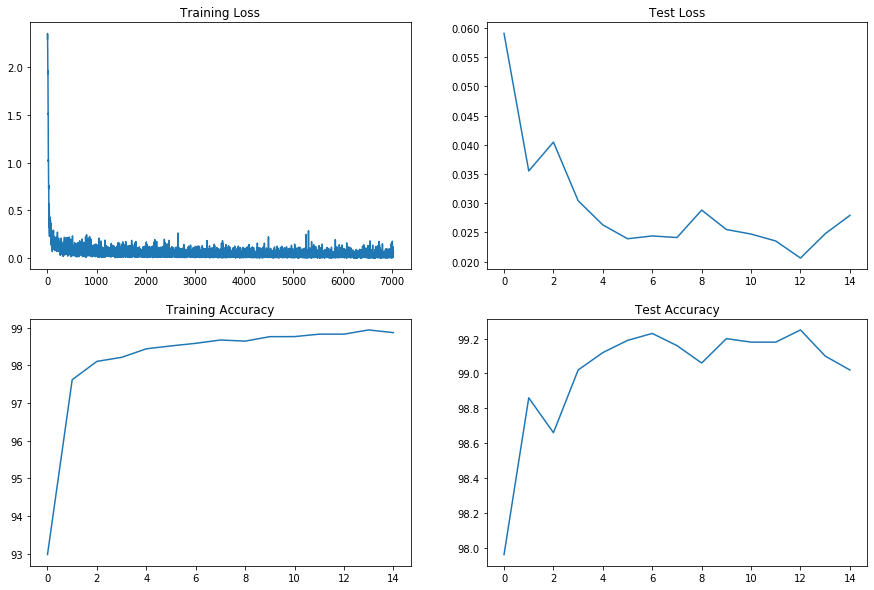

In [38]:

print(f'max train_acc: {max(train_acc)}; max_test_acc : {max(test_acc)}')

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")